# Pre-Processing and Model Training

Using EfficientNetB3

In [57]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import math
import cv2
from sklearn.utils import shuffle
from PIL import Image

In [3]:
train_df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

In [4]:
len(train_df.labels.unique())

12

In [5]:
labels = train_df.labels.unique()

In [6]:
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


The code below begins the process of separating images by class - first making 12 directories and subsequently moving the images the respective directory based on their label.

In [7]:
try:
    os.makedirs('./byclass', exist_ok=False)
except:
    print("Directory Already Created")

Create directories for the different classes, therer are 12 different combinations

In [8]:
for label in labels:
    try:
        os.makedirs('./byclass/'+label, exist_ok=False)
    except:
        print("Directories Already Created")
        break

In [9]:
images = os.listdir('../input/plant-pathology-2021-fgvc8/train_images')

In [10]:
labels

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

In [11]:
train_directories = "./byclass/"
train_image_path = '../input/plant-pathology-2021-fgvc8/train_images/'

In [12]:
try:
    os.makedirs('./extra_test', exist_ok = False)
except:
    print("Extra Test Already Created")

I will set aside 2000 images from the training and validation sets for later testing, so I can properly evaluate the model.

In [13]:
extra_test_path = './extra_test/'

In [14]:
extra_test = train_df[:2000]

In [15]:
extra_test.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [16]:
len(extra_test.labels.unique())

12

Now train_df will become only images from index position 2000 forward, which still leaves ~16,000+ images.

In [17]:
train_df = train_df[2000:]

In [18]:
train_df.head()

,image,labels
2000,905b6691423fc73d.jpg,healthy
2001,905e6078e5d1ef0d.jpg,scab
2002,905f6d3992c26d69.jpg,scab
2003,90617a570fcaa29f.jpg,powdery_mildew
2004,9062169acbcddd4e.jpg,frog_eye_leaf_spot


Move extra test images to their directory

In [19]:
try:
    for image in extra_test.image:
        shutil.copy(train_image_path+image, extra_test_path)
except:
    print("Images already moved")

Move files with the appropriate label to their respective directories

In [20]:
try:
    for label in labels:
        label_df = train_df[train_df.labels == label]
        for image in images:
            image_path = train_image_path + image
            if image in label_df.image.values:
                shutil.copy(image_path, train_directories+label)
except:
    print("Files Already Moved")

In [21]:
from tensorflow.keras import layers

In [22]:
batch_size = 16
image_size = 400
height = 400
width = 400
input_shape = (image_size, image_size, 3)

In [23]:
dropout_rate = .4
classes_to_predict = sorted(train_df.labels.unique())

In [24]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('./byclass/', validation_split=.2, subset ='training',
                                                              seed=123, image_size=(height, width), batch_size=batch_size)

Found 16632 files belonging to 12 classes.
Using 13306 files for training.


In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('./byclass/', validation_split=.2, subset='validation',
                                                            seed=123, image_size=(height, width), batch_size=batch_size)

Found 16632 files belonging to 12 classes.
Using 3326 files for validation.


In [26]:
train_ds.class_names

['complex',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot complex',
 'healthy',
 'powdery_mildew',
 'powdery_mildew complex',
 'rust',
 'rust complex',
 'rust frog_eye_leaf_spot',
 'scab',
 'scab frog_eye_leaf_spot',
 'scab frog_eye_leaf_spot complex']

In [27]:
train_df.labels.value_counts()

scab                               4212
healthy                            4188
frog_eye_leaf_spot                 2883
rust                               1658
complex                            1437
powdery_mildew                     1011
scab frog_eye_leaf_spot             629
scab frog_eye_leaf_spot complex     184
frog_eye_leaf_spot complex          160
rust frog_eye_leaf_spot             105
rust complex                         89
powdery_mildew complex               76
Name: labels, dtype: int64

Here we can balance the class weights by taking 1 - the current number of a particular label and dividing it by 1 minus the smallest in the batch.

In [28]:
current_balance = train_df['labels'].value_counts(normalize=True)

In [29]:
class_weight = {0: (1 - current_balance.iloc[4]) / (1 - current_balance.min()),
                1: (1 - current_balance.iloc[2]) / (1 - current_balance.min()),
                2: (1 - current_balance.iloc[8]) / (1 - current_balance.min()),
                3: (1 - current_balance.iloc[1]) / (1 - current_balance.min()),
                4: (1 - current_balance.iloc[5]) / (1 - current_balance.min()),
                5: (1 - current_balance.iloc[11]) / (1 - current_balance.min()),
                6: (1 - current_balance.iloc[3]) / (1 - current_balance.min()),
                7: (1 - current_balance.iloc[10]) / (1 - current_balance.min()),
                8: (1 - current_balance.iloc[9]) / (1 - current_balance.min()),
                9: (1 - current_balance.iloc[0]) / (1 - current_balance.min()),
                10: (1 - current_balance.iloc[6]) / (1 - current_balance.min()),
                11: (1 - current_balance.iloc[7]) / (1 - current_balance.min())
               }

In [30]:
class_weight

{0: 0.9177941531770959,
 1: 0.8304542159942014,
 2: 0.9949263107030684,
 3: 0.7516308287025851,
 4: 0.9435250060401063,
 5: 1.0,
 6: 0.904445518241121,
 7: 0.9992147861802367,
 8: 0.9982483691712974,
 9: 0.7501812031891761,
 10: 0.9665982121285334,
 11: 0.9934766851896593}

In [31]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=image_size, width=image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [32]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
import matplotlib.pyplot as plt

Define the EfficientNet Model:

In [33]:
def get_EfficientNetB3():
    efficientnet = EfficientNetB3(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=input_shape, 
                                  drop_connect_rate=dropout_rate)

    inputs = Input(shape=input_shape)
    augmented = data_augmentation_layers(inputs)
    efficientnet = efficientnet(augmented)
    pooling = layers.GlobalAveragePooling2D()(efficientnet)
    dropout = layers.Dropout(dropout_rate)(pooling)
    outputs = Dense(len(classes_to_predict), activation="softmax")(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Didn't end up using the normalized layer, but left it anyway.

In [34]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.041097607 0.9917647


In [36]:
from tensorflow.keras.callbacks import EarlyStopping

Set up early stopping to monitor the epochs progress based on validation loss

In [37]:
early_stop = EarlyStopping(monitor='val_loss', verbose=1, min_delta=.001, patience=3)

Cosine decay for learning rate scheduling

In [38]:
epochs = 25
decay_steps = int(round(len(train_df)/batch_size)) * epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=.3)

callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True), early_stop]

In [39]:
model = get_EfficientNetB3()
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=['accuracy'])

43941888/43941136 [==============================] - 1s 0us/step


In [40]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds,
                   callbacks=callbacks, class_weight=class_weight)

Epoch 1/25
832/832 [==============================] - 1297s 2s/step - loss: 0.9544 - accuracy: 0.6655 - val_loss: 0.4850 - val_accuracy: 0.8452
Epoch 2/25
832/832 [==============================] - 1283s 2s/step - loss: 0.4165 - accuracy: 0.8500 - val_loss: 0.4162 - val_accuracy: 0.8653
Epoch 3/25
832/832 [==============================] - 1249s 1s/step - loss: 0.3599 - accuracy: 0.8709 - val_loss: 0.4057 - val_accuracy: 0.8698
Epoch 4/25
832/832 [==============================] - 1251s 1s/step - loss: 0.3232 - accuracy: 0.8831 - val_loss: 0.3610 - val_accuracy: 0.8836
Epoch 5/25
832/832 [==============================] - 1250s 1s/step - loss: 0.2948 - accuracy: 0.8935 - val_loss: 0.3822 - val_accuracy: 0.8779
Epoch 6/25
832/832 [==============================] - 1248s 1s/step - loss: 0.2623 - accuracy: 0.9030 - val_loss: 0.3693 - val_accuracy: 0.8845
Epoch 7/25
832/832 [==============================] - 1249s 1s/step - loss: 0.2488 - accuracy: 0.9071 - val_loss: 0.3626 - val_accuracy:

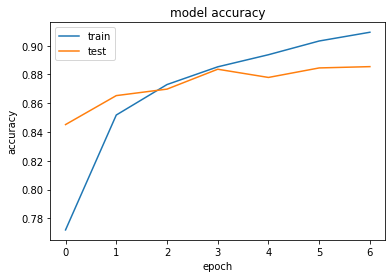

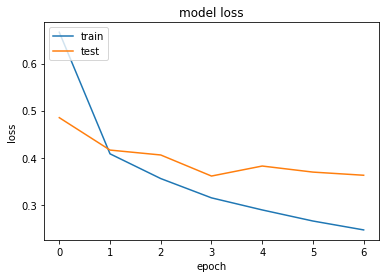

In [41]:
# Accuracy History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###### The below code is specific to a kaggle submission

In [42]:
test_images = os.listdir('../input/plant-pathology-2021-fgvc8/test_images')

In [51]:
test_dir = '../input/plant-pathology-2021-fgvc8/test_images/'

In [52]:
test_images

['ad8770db05586b59.jpg', 'c7b03e718489f3ca.jpg', '85f8cb619c66b863.jpg']

In [53]:
submission = pd.DataFrame(test_images, columns =[image])

In [64]:
def predict_image(image_path):
    image=cv2.imread(image_path)
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height,width))
    p = np.expand_dims(size_image, 0)
    img = tf.cast(p, tf.float32)
    return labels[np.argmax(model.predict(img))]

In [65]:
preds = []
for image in test_images:
    preds.append(predict_image(test_dir + image))
    print(image)

ad8770db05586b59.jpg
c7b03e718489f3ca.jpg
85f8cb619c66b863.jpg


In [66]:
preds

['powdery_mildew complex', 'scab frog_eye_leaf_spot complex', 'healthy']

In [67]:
submission['label'] = preds

In [69]:
submission.columns = ['image', 'label']

In [71]:
submission.set_index('image', inplace=True)

In [73]:
submission

,label
image,
ad8770db05586b59.jpg,powdery_mildew complex
c7b03e718489f3ca.jpg,scab frog_eye_leaf_spot complex
85f8cb619c66b863.jpg,healthy


In [74]:
submission.to_csv('submission.csv')

In [98]:
shutil.rmtree('./extra_test')
shutil.rmtree('./byclass')